Virtual Doctor

Language Model, which does diagnosis and provides recommended next steps, just by inputting symptoms

Text pre-processing, Causal Language Modeling (CLM), Bert, GPT2

Encoding the given text by tokenizers and Bert and then using multihead attention model, inputing that to GPT and then training GPT to give Doctor Diagnosis, and recommend next steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip -q install transformers==2.9.0 gdown

In [ ]:
#hide
# Imports


"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
#collapse
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = 'output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/MedDialog/MedDialog/MedDialog_csv_files/icliniq_dialogue.csv')

In [ ]:
df

,Description,Patient,Doctor
0,Q. What does abutment of the nerve root mean?,"patient: Hi doctor,I am just wondering what is...",doctor: Hi. I have gone through your query wit...
1,"Q. Every time I eat spicy food, I poop blood. ...","patient: Hi doctor,I am a 26 year old male. I ...",doctor: Hello. I have gone through your inform...
2,Q. Will Nano-Leo give permanent solution for e...,"patient: Hello doctor,I am 48 years old. I am ...",doctor: Hi. For further doubts consult a sexol...
3,Q. Will Kalarchikai cure multiple ovarian cyst...,"patient: Hello doctor,I have multiple small cy...",doctor: Hello. I just read your query. See Kal...
4,Q. I masturbate only by rubbing the tip of the...,"patient: Hi doctor,During masturbation I just ...",doctor: Hi. For further doubts consult a sexol...
...,...,...,...
20692,Q. Brother-in-law got a stent for stomach canc...,"patient: Hi doctor,My brother-in-law has stoma...",doctor: Hi. I understand your concern. For fur...
20693,Q. Having osteoporosis and spine fracture. How...,"patient: Hi doctor,I have osteoporosis and L3 ...",doctor: Hi. I have gone through your message a...
20694,Q. How long should I take Humira?,"patient: Hi doctor,I am a 55 year old male. I ...",doctor: Hello. For further information consult...
20695,Q. Tried withdrawal method and took I-pill. Am...,"patient: Hi doctor,I had unprotected sex and t...",doctor: Hi. For further information consult an...


In [ ]:
df=df[['Doctor','Patient']]

In [ ]:
df = df.dropna()
trn_df, val_df = train_test_split(df, test_size = 0.2)
trn_df.head()

,Doctor,Patient
7559,"doctor: Hi. Well, not only the LDL (low-densit...","patient: Hi doctor,I am a 28-year-old male. My..."
14401,doctor: Hello. Considering the inflammatory bo...,"patient: Hello doctor,I had abdominal pain six..."
1809,doctor: Hello. The gums looked blanched or whi...,"patient: Hi doctor, I have a question about my..."
12817,doctor: Hi. For further information consult a ...,"patient: Hi doctor,I have a small lump on the ..."
6987,doctor: Hi. After carefully reading your compl...,"patient: Hello doctor,For a couple of months, ..."


In [ ]:
#hide
from collections import Counter
from statistics import mean, median, stdev
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#collapse
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
#collapse
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

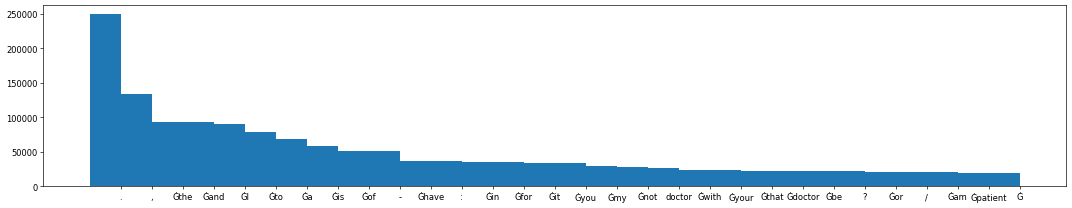

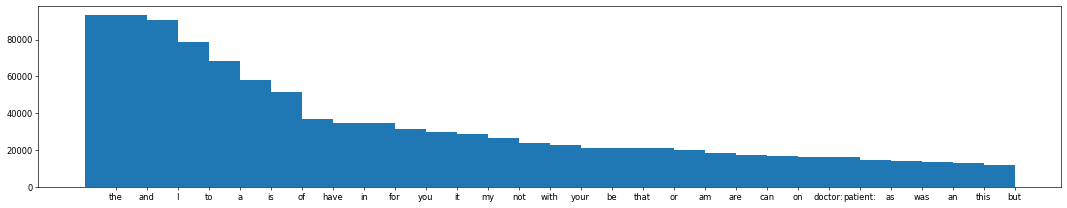

In [ ]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [ ]:
#collapse
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 262.2090354532826, Median: 230, Standard Deviation: 151.36928445338555, 90th Percentile: 1908.0


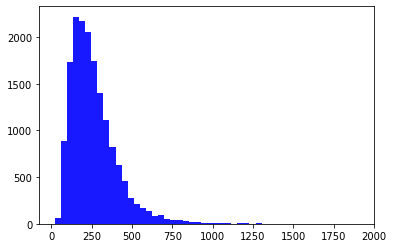

In [ ]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)

In [ ]:
#collapse
def construct_conv(row, tokenizer, eos = True):
    # from: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.max_len - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                if len(conv) > block_size: continue
                self.examples.append(conv)

            # Note that we are loosing the last truncated example here for the sake of simplicity (no padding)
            # If your dataset is small, first you should loook for a bigger one :-) and second you
            # can change this behavior by adding (model specific) padding.

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [ ]:
#hide
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [ ]:
#collapse
# Training of model

def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
#collapse
# Main show runner

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [ ]:
main(trn_df,val_df)

03/05/2022 01:31:11 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/05/2022 01:31:11 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/microsoft/DialoGPT-small/config.json from cache at cached/c3a09526c725b854c685b72cf60c50f1fea9b0e4d6227fa41573425ef4bd4bc6.36332ed8c811a8f0488055ce93ce78909e2f8e027955fba2faa82bfc6728105b
03/05/2022 01:31:11 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,


Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

03/05/2022 01:31:25 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/microsoft/DialoGPT-small/pytorch_model.bin in cache at cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8c26470f335b7c0e46a21483
03/05/2022 01:31:25 - INFO - transformers.file_utils -   creating metadata file for cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8c26470f335b7c0e46a21483
03/05/2022 01:31:25 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/microsoft/DialoGPT-small/pytorch_model.bin from cache at cached/9eab12d0b721ee394e9fe577f35d9b8b22de89e1d4f6a89b8a76d6e1a82bceae.906a78bee3add2ff536ac7ef16753bb3afb3a1cf8c26470f335b7c0e46a21483
03/05/2022 01:31:29 - INFO - transformers.modeling_utils -   Weights of GPT2LMHeadModel not initialized from pretrained model: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3895 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:148: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  w = torch.where(mask, w, self.masked_bias)
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
03/05/2022 01:46:55 - I

Iteration:   0%|          | 0/3895 [00:00<?, ?it/s]

03/05/2022 02:01:45 - INFO - transformers.configuration_utils -   Configuration saved in output/checkpoint-7000/config.json
03/05/2022 02:01:46 - INFO - transformers.modeling_utils -   Model weights saved in output/checkpoint-7000/pytorch_model.bin
03/05/2022 02:01:47 - INFO - __main__ -   Saving model checkpoint to output/checkpoint-7000
03/05/2022 02:01:51 - INFO - __main__ -   Saving optimizer and scheduler states to output/checkpoint-7000


Iteration:   0%|          | 0/3895 [00:00<?, ?it/s]

03/05/2022 02:16:37 - INFO - transformers.configuration_utils -   Configuration saved in output/checkpoint-10500/config.json
03/05/2022 02:16:39 - INFO - transformers.modeling_utils -   Model weights saved in output/checkpoint-10500/pytorch_model.bin
03/05/2022 02:16:39 - INFO - __main__ -   Saving model checkpoint to output/checkpoint-10500
03/05/2022 02:16:43 - INFO - __main__ -   Saving optimizer and scheduler states to output/checkpoint-10500
03/05/2022 02:21:40 - INFO - __main__ -    global_step = 11685, average loss = 1.8872064640647486
03/05/2022 02:21:40 - INFO - __main__ -   Saving model checkpoint to output
03/05/2022 02:21:40 - INFO - transformers.configuration_utils -   Configuration saved in output/config.json
03/05/2022 02:21:42 - INFO - transformers.modeling_utils -   Model weights saved in output/pytorch_model.bin
03/05/2022 02:21:42 - INFO - transformers.configuration_utils -   loading configuration file output/config.json
03/05/2022 02:21:42 - INFO - transformers.conf

Evaluating:   0%|          | 0/979 [00:00<?, ?it/s]

03/05/2022 02:23:15 - INFO - __main__ -   ***** Eval results  *****
03/05/2022 02:23:15 - INFO - __main__ -     perplexity = tensor(5.7337)


{'perplexity_': tensor(5.7337)}

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
model = AutoModelWithLMHead.from_pretrained('output')

# Let's chat for 5 lines
for step in range(6):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=1000,
        pad_token_id=tokenizer.eos_token_id,
        top_p=0.92, top_k = 50
    )
    
    # pretty print last ouput tokens from bot
    print(">> DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

03/05/2022 02:41:39 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/microsoft/DialoGPT-small/config.json from cache at /root/.cache/torch/transformers/c3a09526c725b854c685b72cf60c50f1fea9b0e4d6227fa41573425ef4bd4bc6.36332ed8c811a8f0488055ce93ce78909e2f8e027955fba2faa82bfc6728105b
03/05/2022 02:41:39 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_param

>> User:Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?
DialoGPT: doctor: Hi. For further information consult a neurologist online --> https://www.icliniq.com/ask-a-doctor-online/neurologist
>> User:I am a 26 year old male. I am 5 feet and 9 inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached.
DialoGPT: !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!